In [89]:
import torch as t
from typing import Union
from torch import nn
import numpy as np
import torch.nn.functional as F
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import torchvision
from matplotlib import pyplot as plt
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange
from fancy_einsum import einsum
import os
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, TensorDataset
from pytorch_lightning.callbacks.progress import TQDMProgressBar
import PIL
import wandb
from dataclasses import dataclass
import pytorch_lightning as pl

In [72]:
from typing import Tuple


@dataclass
class AEargs():
    in_features: int = 784
    hidden_dim: int = 100
    out_features: int = 10
    batch_size: int = 8
    epochs: int = 5
    lr: float = 0.0002
    betas: Tuple[float] = (0.99, 0.999)
    track: bool = False
    cuda: bool = False

In [17]:
class Autoencoder(nn.Module):
    encoder: nn.Sequential
    decoder: nn.Sequential

    def __init__(self, args: AEargs):
        super().__init__()
        self.encoder = nn.Sequential(
            Rearrange('b c h w -> b (c h w)'),
            nn.Linear(in_features=args.in_features, out_features=args.hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=args.hidden_dim, out_features=args.out_features),
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=args.out_features, out_features=args.hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=args.hidden_dim, out_features=args.in_features),
            Rearrange('b (c h w) -> b c h w', h=28, w=28),
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        x_compressed = self.encoder(x)
        x_reconstructed = self.decoder(x_compressed)
        return x_reconstructed

In [81]:
class AutoEncoderPL(pl.LightningModule):
    def __init__(self, args: AEargs):
        super().__init__()
        self.args = args
        self.encoder = nn.Sequential(
            Rearrange('b c h w -> b (c h w)'),
            nn.Linear(in_features=args.in_features, out_features=args.hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=args.hidden_dim, out_features=args.out_features),
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=args.out_features, out_features=args.hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=args.hidden_dim, out_features=args.in_features),
            Rearrange('b (c h w) -> b c h w', h=28, w=28),
        )
        self.criterion = nn.MSELoss()

    def forward(self, x: t.Tensor) -> t.Tensor:
        x_compressed = self.encoder(x)
        x_reconstructed = self.decoder(x_compressed)
        return x_reconstructed

    def training_step(self, batch, batch_idx):
        x, y = batch
        #print(x.shape, y.shape)
        y_hat = self(x)
        #print(y_hat.shape)
        loss = self.criterion(y_hat, x)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, x)
        self.log('val_loss', loss)
        

    def configure_optimizers(self):
        optimizer = t.optim.Adam(self.parameters(), lr=self.args.lr, betas=self.args.betas)
        return optimizer

In [82]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
testset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)

In [83]:
args = AEargs()
model = AutoEncoderPL(args)
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if t.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=15,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [84]:
trainer.fit(train_dataloaders=trainloader, val_dataloaders=testloader, model=model)


  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 79.5 K
1 | decoder   | Sequential | 80.3 K
2 | criterion | MSELoss    | 0     
-----------------------------------------
159 K     Trainable params
0         Non-trainable params
159 K     Total params
0.639     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/curttigges/miniconda3/envs/arena/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/curttigges/miniconda3/envs/arena/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/curttigges/miniconda3/envs/arena/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [91]:
def make_scatter_plot(trainset, n_examples=1000):
    trainloader = DataLoader(trainset, batch_size=64)
    df_list = []
    device = next(model.parameters()).device
    for img, label in trainloader:
        output = model.encoder(img.to(device)).detach().cpu().numpy()
        for label_single, output_single in zip(label, output):
            df_list.append({
                "x0": output_single[0],
                "x1": output_single[1],
                "label": str(label_single.item()),
            })
        if (n_examples is not None) and (len(df_list) >= n_examples):
            break
    df = pd.DataFrame(df_list)
    fig = px.scatter(df, x="x0", y="x1", color="label")
    fig.show()


make_scatter_plot(trainset, n_examples=2000)

In [85]:
output = model(next(iter(trainloader))[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


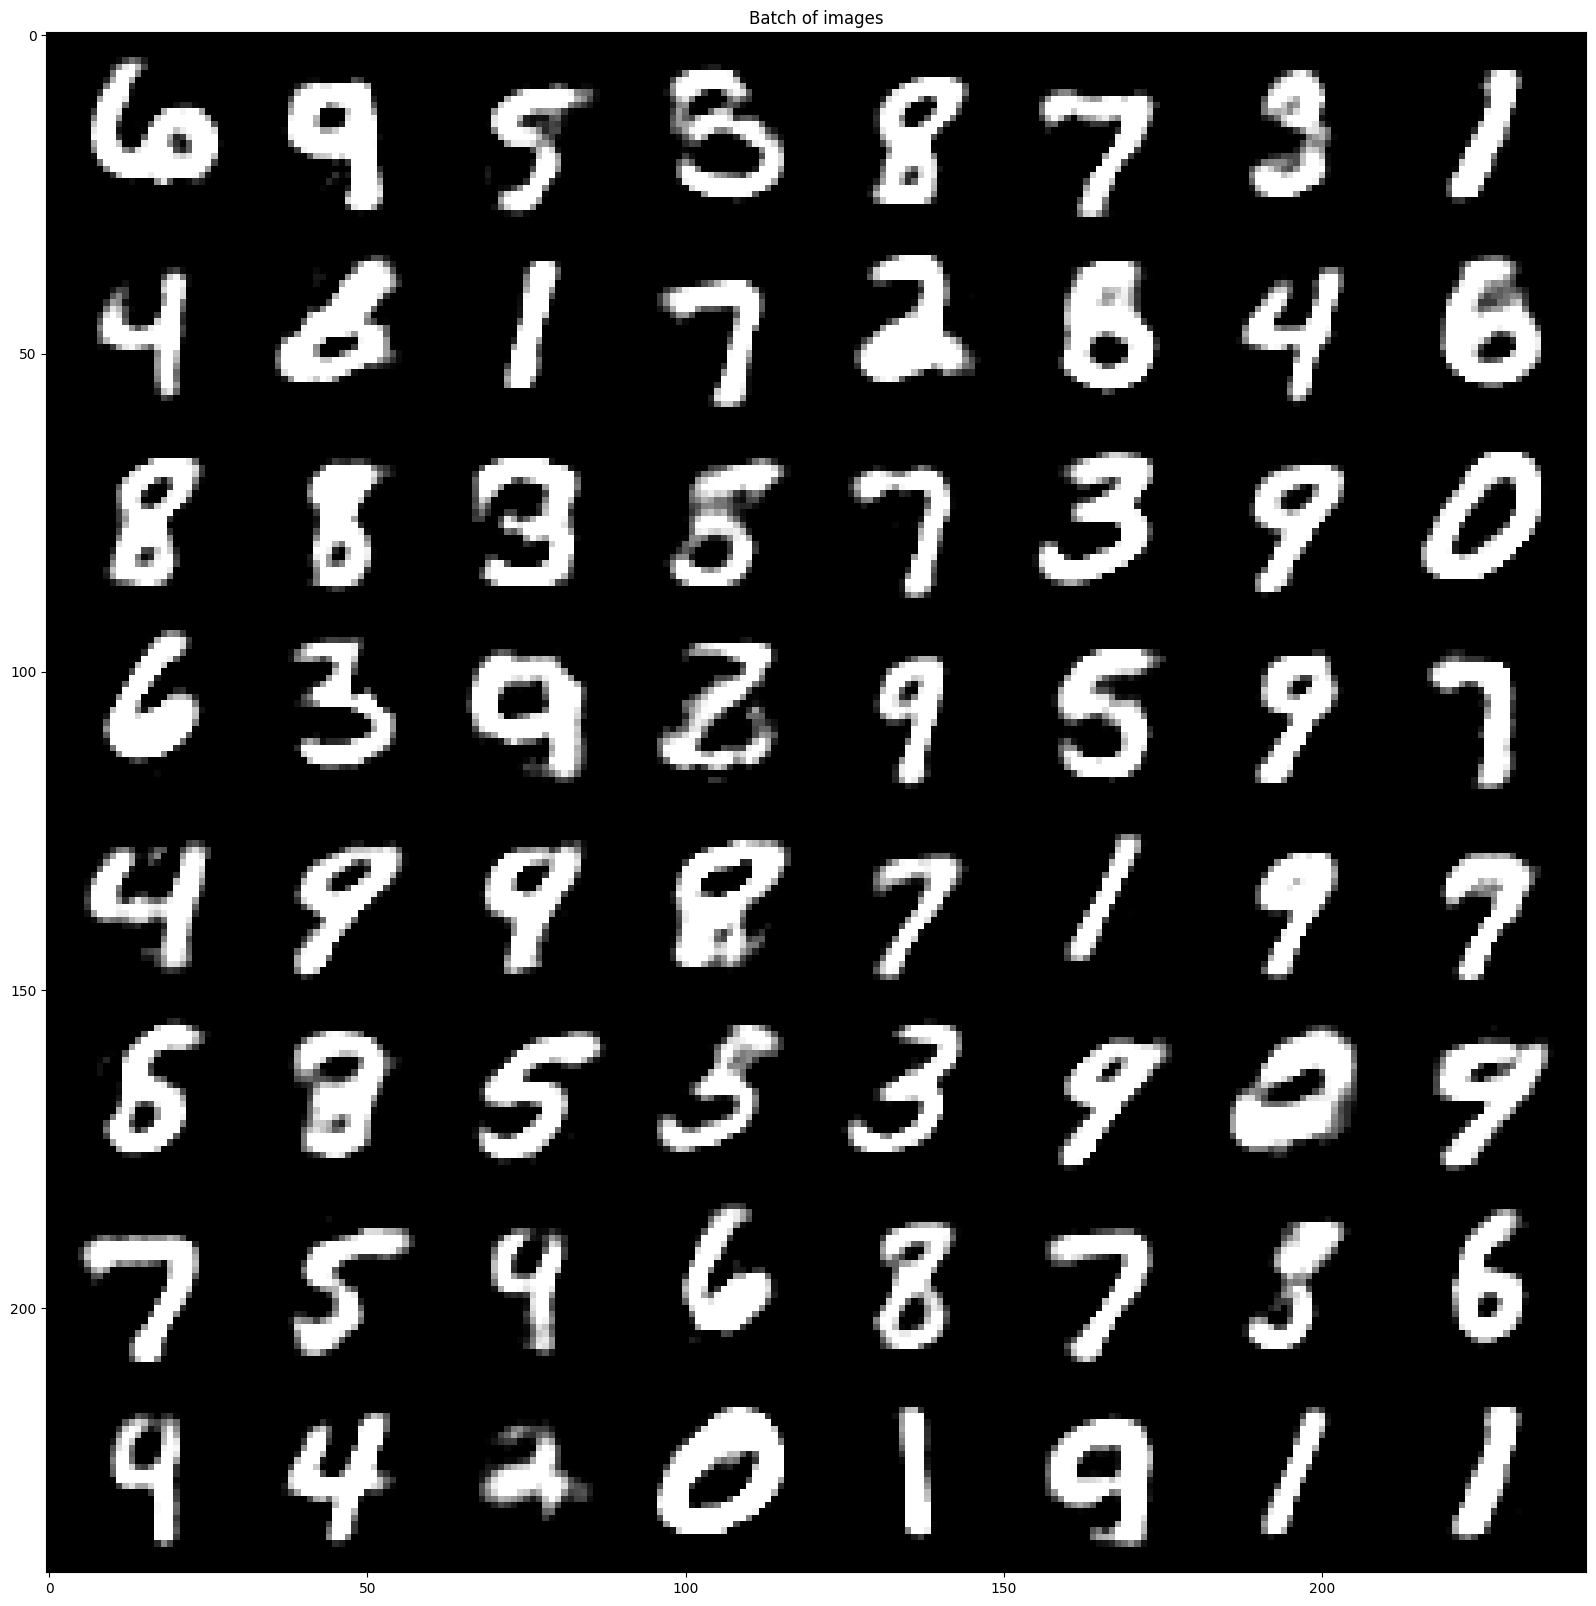

In [86]:
from w5d1_utils import show_images

def display_image_batch(batch: t.Tensor, nrow: int = 8, title: str = "Batch of images"):
    """Function to display a batch of images using PIL"""
    batch = batch.detach().cpu()
    grid = torchvision.utils.make_grid(batch, nrow=nrow)
    plt.figure(figsize=(20, 20))
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()
    
display_image_batch(output)


In [88]:
# Choose number of interpolation points
n_points = 11

# Constructing latent dim data by making two of the dimensions vary independently between 0 and 1
latent_dim_data = t.zeros((n_points, n_points, args.out_features), device='cpu')
x = t.linspace(-1, 1, n_points)
latent_dim_data[:, :, 0] = x.unsqueeze(0)
latent_dim_data[:, :, 1] = x.unsqueeze(1)
# Rearranging so we have a single batch dimension
latent_dim_data = rearrange(latent_dim_data, "b1 b2 latent_dim -> (b1 b2) latent_dim")

# Getting model output, and normalising & truncating it in the range [0, 1]
output = model.decoder(latent_dim_data).detach().cpu().numpy()
output_truncated = np.clip((output * 0.3081) + 0.1307, 0, 1)
output_single_image = rearrange(output_truncated, "(b1 b2) 1 height width -> (b1 height) (b2 width)", b1=n_points)

# Plotting results
fig = px.imshow(output_single_image, color_continuous_scale="greys_r")
fig.update_layout(
    title_text="Decoder output from varying first two latent space dims", title_x=0.5,
    coloraxis_showscale=False, 
    xaxis=dict(tickmode="array", tickvals=list(range(14, 14+28*n_points, 28)), ticktext=[f"{i:.2f}" for i in x]),
    yaxis=dict(tickmode="array", tickvals=list(range(14, 14+28*n_points, 28)), ticktext=[f"{i:.2f}" for i in x])
)
fig.show()